In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Dark2")

results = pd.read_parquet("./sampling_scaling_rtt.gzip")

# only look at the empirical-high timing model (ground truth)
results = results[results["timing_model"] == "empirical-high"].copy()
results["timing_model"] = results["timing_model"].cat.remove_unused_categories()


def _classify_sampling(s: str) -> str:
    ssplit = s.split("-")
    if len(ssplit) > 1:
        if ssplit[0] == "adaptive":
            if ssplit[1] == "power":
                return "adaptive-energy"
            else:
                return "adaptive-ttf"
        return ssplit[0]
    else:
        return "reference"


results["sampling_class"] = (
    results["sampling_scheme"]
    .apply(_classify_sampling)
    .astype(pd.CategoricalDtype(["adaptive-energy", "adaptive-ttf", "reference", "periodic", "hold"]))
)

included_schemes = ['greedy',
                    'ideal',
                    'adaptive-power-empirical',
                    'adaptive-power-empirical-low',
                    'adaptive-power-empirical-high',
                    'adaptive-power-theoretical-exgaussian',
                    'adaptive-power-theoretical-exgaussian-low',
                    'adaptive-power-theoretical-exgaussian-high',
                    'adaptive-power-fitted-naive-exgaussian']

results = results[np.isin(results["sampling_scheme"], included_schemes)]
results["sampling_scheme"] = results["sampling_scheme"].astype(pd.CategoricalDtype(included_schemes, ordered=True))
results["success_sample_instant"] = results["execution_time"] + results["wait_time"]

results

,rtt,step,previous_ttf,execution_time,step_duration,ttf,wait_time,samples,cumulative_duration,cumulative_samples,...,energy,cumulative_energy,comm_time,idle_time,comm_energy,idle_energy,timing_model,sampling_scheme,sampling_class,success_sample_instant
0,3.0,1,3.000000,5.165943,11.234973,6.069030,3.069030,1,11.234973,1,...,0.249525,0.249525,2.7,8.534973,0.1215,0.128025,empirical-high,adaptive-power-empirical-high,adaptive-energy,8.234973
1,3.0,2,6.069030,5.494208,11.431029,5.936821,2.936821,1,22.666002,2,...,0.252465,0.501990,2.7,8.731029,0.1215,0.130965,empirical-high,adaptive-power-empirical-high,adaptive-energy,8.431029
2,3.0,3,5.936821,4.627879,11.431029,6.803151,3.803151,1,34.097031,3,...,0.252465,0.754455,2.7,8.731029,0.1215,0.130965,empirical-high,adaptive-power-empirical-high,adaptive-energy,8.431029
3,3.0,4,6.803151,6.140092,11.431029,5.290937,2.290937,1,45.528060,4,...,0.252465,1.006921,2.7,8.731029,0.1215,0.130965,empirical-high,adaptive-power-empirical-high,adaptive-energy,8.431029
4,3.0,5,5.290937,9.021117,16.383425,7.362308,4.362308,2,61.911485,6,...,0.407751,1.414672,5.4,10.983425,0.2430,0.164751,empirical-high,adaptive-power-empirical-high,adaptive-energy,13.383425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242995,2.0,116,2.000000,3.712261,5.712261,2.000000,0.000000,1,907.013672,116,...,0.136684,19.521205,1.7,4.012261,0.0765,0.060184,empirical-high,ideal,reference,3.712261
242996,2.0,117,2.000000,5.539808,7.539808,2.000000,0.000000,1,914.553480,117,...,0.164097,19.685302,1.7,5.839808,0.0765,0.087597,empirical-high,ideal,reference,5.539808
242997,2.0,118,2.000000,8.035280,10.035280,2.000000,0.000000,1,924.588760,118,...,0.201529,19.886831,1.7,8.335280,0.0765,0.125029,empirical-high,ideal,reference,8.035280
242998,2.0,119,2.000000,10.014812,12.014812,2.000000,0.000000,1,936.603572,119,...,0.231222,20.118054,1.7,10.314812,0.0765,0.154722,empirical-high,ideal,reference,10.014812


In [42]:
power_consts = {
    # "comm": 0.045,
    "comm": 0.045,
    "idle": 0.015
}  # Watts

mean_power = (
    results.groupby(["sampling_class", "sampling_scheme", "rtt", "repetition"], observed=True)
    [["samples", "idle_time", "comm_time", "step_duration"]]
    .sum()
    .reset_index()
    .copy()
)
mean_power["comm_time"] = mean_power["samples"] * (mean_power["rtt"] - 0.3)
mean_power["comm_energy"] = mean_power["comm_time"] * power_consts["comm"]
mean_power["idle_time"] = mean_power["step_duration"] - mean_power["comm_time"]
mean_power["idle_energy"] = mean_power["idle_time"] * power_consts["idle"]

mean_power["total_energy"] = mean_power["idle_energy"] + mean_power["comm_energy"]
mean_power["power"] = mean_power["total_energy"] / mean_power["step_duration"]
mean_power

,sampling_class,sampling_scheme,rtt,repetition,samples,idle_time,comm_time,step_duration,comm_energy,idle_energy,total_energy,power
0,adaptive-energy,adaptive-power-empirical,1.0,1,207,828.857490,144.9,973.757490,6.5205,12.432862,18.953362,0.019464
1,adaptive-energy,adaptive-power-empirical,1.0,2,250,924.617027,175.0,1099.617027,7.8750,13.869255,21.744255,0.019774
2,adaptive-energy,adaptive-power-empirical,1.0,3,204,834.516207,142.8,977.316207,6.4260,12.517743,18.943743,0.019383
3,adaptive-energy,adaptive-power-empirical,1.0,4,211,849.527562,147.7,997.227562,6.6465,12.742913,19.389413,0.019443
4,adaptive-energy,adaptive-power-empirical,1.0,5,226,877.486258,158.2,1035.686258,7.1190,13.162294,20.281294,0.019582
...,...,...,...,...,...,...,...,...,...,...,...,...
2020,reference,ideal,5.0,41,120,898.391300,564.0,1462.391300,25.3800,13.475869,38.855869,0.026570
2021,reference,ideal,5.0,42,120,920.925706,564.0,1484.925706,25.3800,13.813886,39.193886,0.026395
2022,reference,ideal,5.0,43,120,840.611840,564.0,1404.611840,25.3800,12.609178,37.989178,0.027046
2023,reference,ideal,5.0,44,120,941.120147,564.0,1505.120147,25.3800,14.116802,39.496802,0.026242


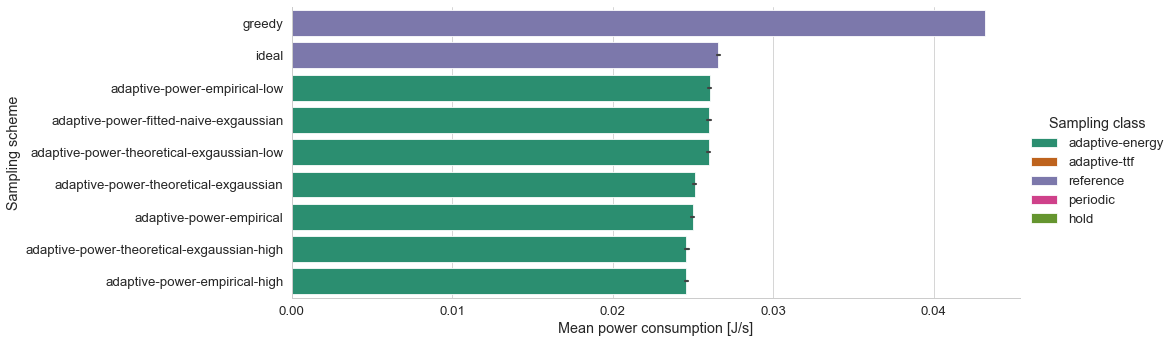

In [43]:
power_max_rtt = mean_power[mean_power["rtt"] == mean_power["rtt"].max()]

fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=power_max_rtt,
    x="power",
    y="sampling_scheme",
    order=(
        power_max_rtt
        .groupby(["sampling_scheme"])
        ["power"]
        .mean()
        .sort_values(ascending=False)
        .index
    ),
    hue="sampling_class",
    aspect=3,
    dodge=False,
)
fg.set_axis_labels("Mean power consumption [J/s]", "Sampling scheme")
fg.legend.set_title("Sampling class")
plt.show()

In [50]:
import scipy.stats as stats
import itertools as it

p_values = pd.DataFrame(index=included_schemes, columns=included_schemes, dtype=float)
for row, col in it.product(included_schemes, included_schemes):
    if row == col:
        continue
    t_stat, p_val = stats.ttest_ind(
        mean_power.loc[mean_power["sampling_scheme"] == row, "power"].to_numpy(),
        mean_power.loc[mean_power["sampling_scheme"] == col, "power"].to_numpy(),
        alternative="two-sided",
        # null-hypothesis is that energies have the same mean and that the observed difference is just random
    )
    p_values.at[row, col] = p_val

    # cols.remove(row)
# p_values.style.format(lambda e: "p < 0.05" if e < 0.05 else "Not significant")

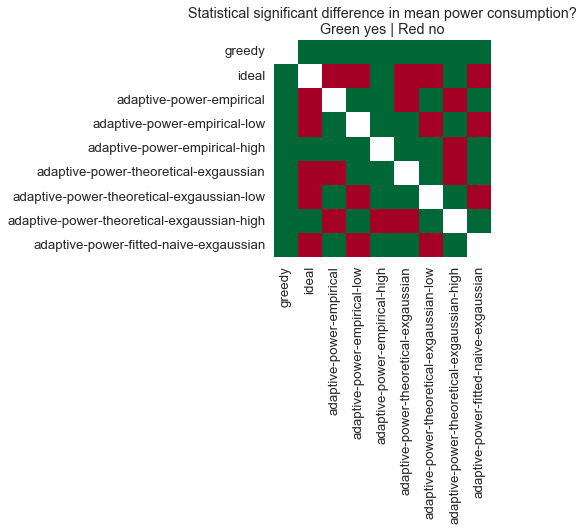

In [52]:
significant = p_values < 0.05
significant[p_values.isna()] = np.NaN
for c in significant.columns:
    significant[c] = significant[c].astype(float)

ax = sns.heatmap(
    significant,
    square=True,
    # annot=True,
    # center=0.05,
    cbar=False,
    cmap="RdYlGn",
)
ax.set_title("Statistical significant difference in mean power consumption?\n"
             "Green yes | Red no")
plt.show()

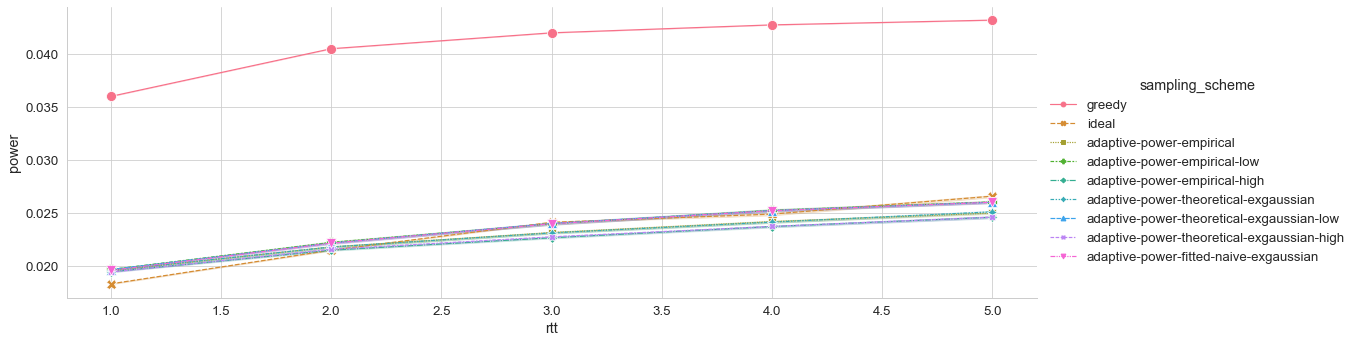

In [47]:
fg = sns.relplot(
    kind="line",
    data=mean_power,
    x="rtt",
    y="power",
    style="sampling_scheme",
    hue="sampling_scheme",
    markers=True,
    aspect=3,
    markersize=10,
)
plt.show()

In [2]:
results_per_rep = (
    results
    .groupby(["timing_model", "sampling_scheme", "sampling_class", "rtt", "repetition"], observed=True)
    [["execution_time", "step_duration", "ttf", "wait_time", "samples", "energy", "idle_energy", "comm_energy", "idle_time", "comm_time", "success_sample_instant"]]
    .mean()
    .reset_index()
)
results_per_rep

,timing_model,sampling_scheme,sampling_class,rtt,repetition,execution_time,step_duration,ttf,wait_time,samples,energy,idle_energy,comm_energy,idle_time,comm_time,success_sample_instant
0,empirical-high,greedy,reference,1.0,1,5.731737,7.216667,1.484930,0.484930,7.216667,0.259800,0.032475,0.227325,2.165000,5.051667,6.216667
1,empirical-high,greedy,reference,1.0,2,5.945237,7.458333,1.513096,0.513096,7.458333,0.268500,0.033563,0.234937,2.237500,5.220833,6.458333
2,empirical-high,greedy,reference,1.0,3,6.409673,7.966667,1.556994,0.556994,7.966667,0.286800,0.035850,0.250950,2.390000,5.576667,6.966667
3,empirical-high,greedy,reference,1.0,4,5.269168,6.766667,1.497499,0.497499,6.766667,0.243600,0.030450,0.213150,2.030000,4.736667,5.766667
4,empirical-high,greedy,reference,1.0,5,5.925383,7.450000,1.524617,0.524617,7.450000,0.268200,0.033525,0.234675,2.235000,5.215000,6.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,41,7.398076,16.188302,8.790226,3.790226,1.266667,0.421425,0.153525,0.267900,10.234968,5.953333,11.188302
2021,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,42,7.356517,16.265826,8.909309,3.909309,1.291667,0.426112,0.152925,0.273187,10.194993,6.070833,11.265826
2022,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,43,7.332996,16.253706,8.920710,3.920710,1.275000,0.423581,0.153918,0.269662,10.261206,5.992500,11.253706
2023,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,44,6.596412,15.575296,8.978884,3.978884,1.150000,0.395779,0.152554,0.243225,10.170296,5.405000,10.575296


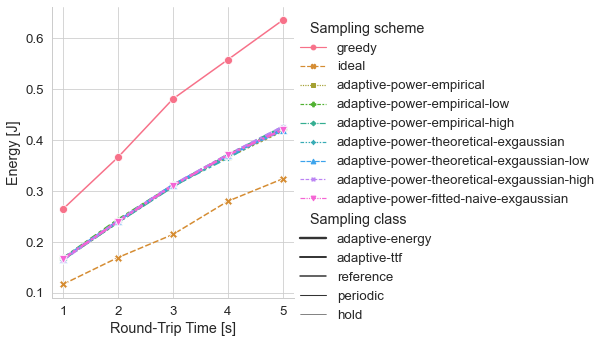

In [3]:
fg = sns.relplot(
    kind="line",
    errorbar=None,
    data=results_per_rep.rename(columns={"sampling_scheme": "Sampling scheme", "sampling_class": "Sampling class"}),
    x="rtt",
    y="energy",
    hue="Sampling scheme",
    style="Sampling scheme",
    size="Sampling class",
    markers=True,
    aspect=1,
    markersize=8,
)
fg.set_axis_labels("Round-Trip Time [s]", "Energy [J]")
# fg.legend.set_title("Sampling Scheme")
plt.show()

In [4]:
energy_at_max_rtt = (
    results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()]
    .groupby("sampling_scheme")
    ["energy"]
    .mean()
    .sort_values()
)
energy_at_max_rtt

sampling_scheme
ideal                                         0.323791
adaptive-power-empirical                      0.418106
adaptive-power-theoretical-exgaussian-low     0.419250
adaptive-power-fitted-naive-exgaussian        0.420458
adaptive-power-empirical-low                  0.420902
adaptive-power-theoretical-exgaussian         0.423419
adaptive-power-empirical-high                 0.425744
adaptive-power-theoretical-exgaussian-high    0.426076
greedy                                        0.635760
Name: energy, dtype: float64

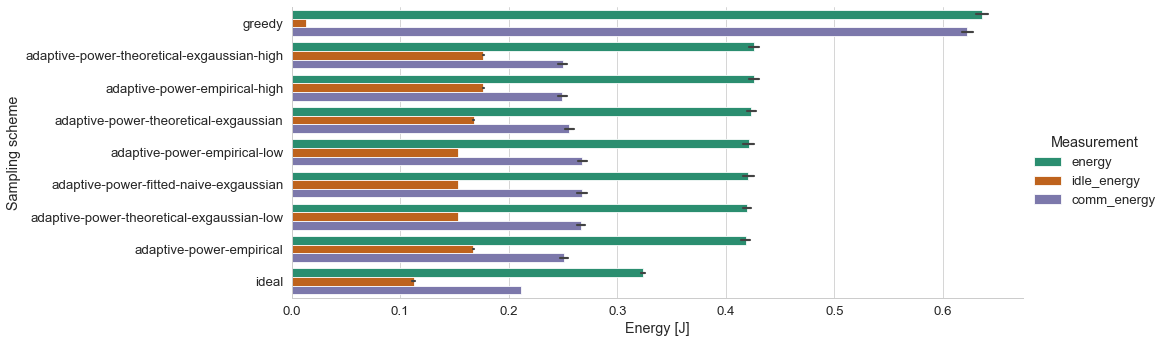

In [5]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=(
        results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()]
        [["sampling_scheme", "energy", "idle_energy", "comm_energy"]]
        .set_index("sampling_scheme")
        .stack()
        .reset_index()
        .rename(columns={"level_1": "energy", 0: "value"})
    ),
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="value",
    # join=False,
    hue="energy",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=True,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Energy [J]", "Sampling scheme")
fg.legend.set_title("Measurement")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.10588235294117647, 0.6196078431372549, 0.4666666666666667)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.8509803921568627, 0.37254901960784315, 0.00784313725490196)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.4588235294117647, 0.4392156862745098, 0.7019607843137254)) for an unfilled marker ('+').  Matplotlib is ignoring

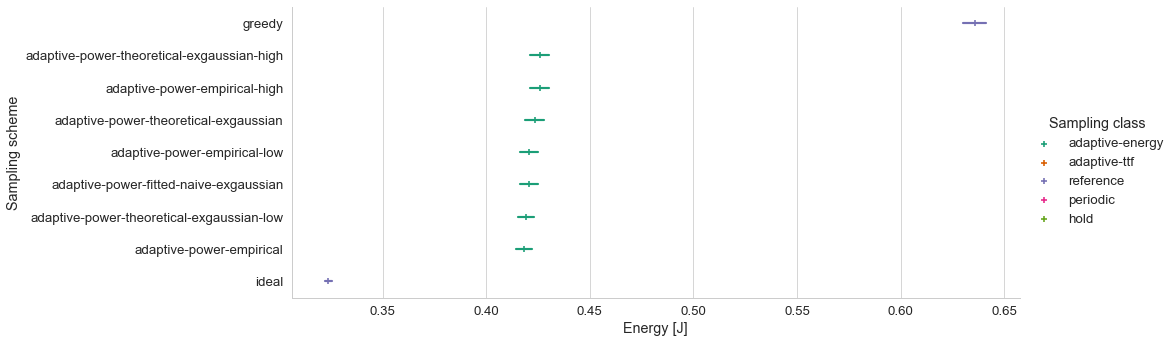

In [6]:
fg = sns.catplot(
    kind="point",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="energy",
    join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    markers="+",
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Energy [J]", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

test if difference between mean energies at max rtt is statistically significant!
null hypothesis is that all sampling schemes have the same mean

In [7]:
import scipy.stats as stats

# import itertools as it

energies = (
    results_per_rep
    .loc[(results_per_rep["rtt"] == results_per_rep["rtt"].max())]
    .copy()
)

p_values = pd.DataFrame(index=included_schemes, columns=included_schemes, dtype=float)
cols = set(included_schemes)
last_row = len(included_schemes)
for row in included_schemes:
    for col in cols:
        if row == col:
            continue
        t_stat, p_val = stats.ttest_ind(
            energies.loc[energies["sampling_scheme"] == row, "energy"].to_numpy(),
            energies.loc[energies["sampling_scheme"] == col, "energy"].to_numpy(),
            alternative="two-sided",
            # null-hypothesis is that energies have the same mean and that the observed difference is just random
        )
        p_values.at[row, col] = p_val

    # cols.remove(row)
p_values.style.format(lambda e: "p < 0.05" if e < 0.05 else "Not significant")

,greedy,ideal,adaptive-power-empirical,adaptive-power-empirical-low,adaptive-power-empirical-high,adaptive-power-theoretical-exgaussian,adaptive-power-theoretical-exgaussian-low,adaptive-power-theoretical-exgaussian-high,adaptive-power-fitted-naive-exgaussian
greedy,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
ideal,p < 0.05,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-empirical,p < 0.05,p < 0.05,Not significant,Not significant,p < 0.05,Not significant,Not significant,p < 0.05,Not significant
adaptive-power-empirical-low,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant
adaptive-power-empirical-high,p < 0.05,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,p < 0.05,Not significant,Not significant
adaptive-power-theoretical-exgaussian,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant
adaptive-power-theoretical-exgaussian-low,p < 0.05,p < 0.05,Not significant,Not significant,p < 0.05,Not significant,Not significant,p < 0.05,Not significant
adaptive-power-theoretical-exgaussian-high,p < 0.05,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,p < 0.05,Not significant,Not significant
adaptive-power-fitted-naive-exgaussian,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant


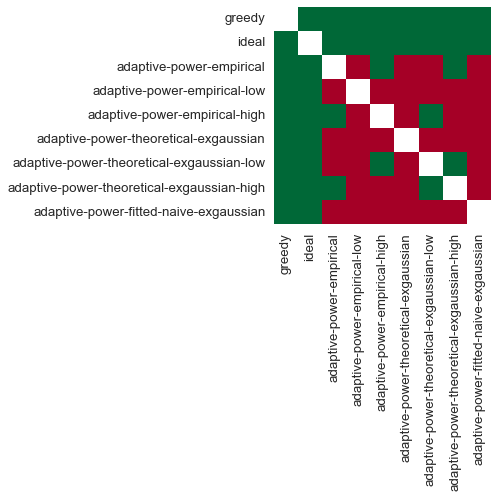

In [8]:
significant = p_values < 0.05
significant[p_values.isna()] = np.NaN
for c in significant.columns:
    significant[c] = significant[c].astype(float)

ax = sns.heatmap(
    significant,
    square=True,
    # annot=True,
    # center=0.05,
    cbar=False,
    cmap="RdYlGn",
)
plt.show()


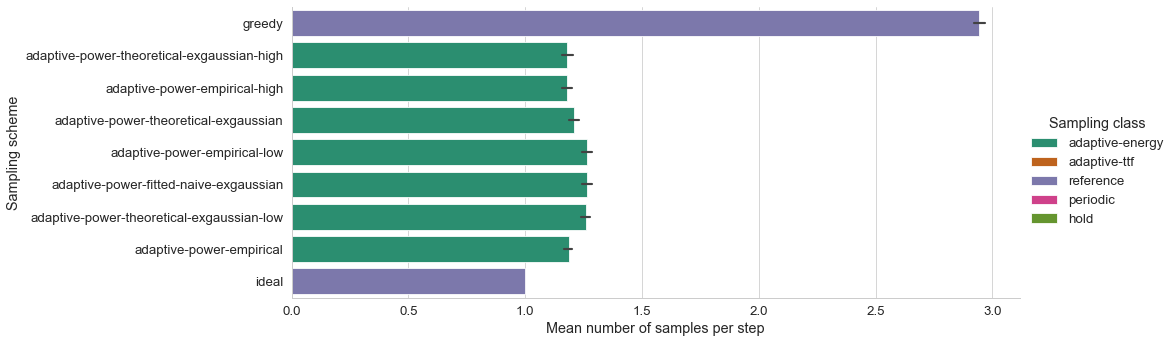

In [9]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="samples",
    # join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=False,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Mean number of samples per step", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

In [10]:
(
    results[results["rtt"] == results["rtt"].max()]
    .groupby("sampling_scheme")
    ["samples"]
    .value_counts()
    .loc[pd.IndexSlice["adaptive-power-empirical-high"], :]
    .to_frame()
    .rename(columns={"samples": "counts"})
    .reset_index()
    .sort_values("samples")
)

,samples,counts
0,1,4848
1,2,371
2,3,82
5,4,2
3,5,65
4,6,31
6,8,1


In [11]:
(
    results[results["rtt"] == results["rtt"].max()]
    .groupby(["sampling_scheme", "samples"], observed=True)
    ["wait_time"]
    .describe()
    .loc["adaptive-power-empirical-high", :]
)

,count,mean,std,min,25%,50%,75%,max
samples,,,,,,,,
1,4848.0,5.047294,2.200979,0.076728,3.625887,5.134127,6.890534,10.968521
2,371.0,4.775471,1.911281,0.005345,3.553901,5.654586,6.133914,6.601627
3,82.0,3.745980,0.403500,1.698327,3.601863,3.981555,3.981555,4.429912
4,2.0,3.799172,0.000000,3.799172,3.799172,3.799172,3.799172,3.799172
5,65.0,2.004752,0.297327,1.817776,1.817776,2.118697,2.118697,4.040825
6,31.0,4.611545,0.276259,3.123018,4.661162,4.661162,4.661162,4.661162
8,1.0,0.789072,NaN,0.789072,0.789072,0.789072,0.789072,0.789072


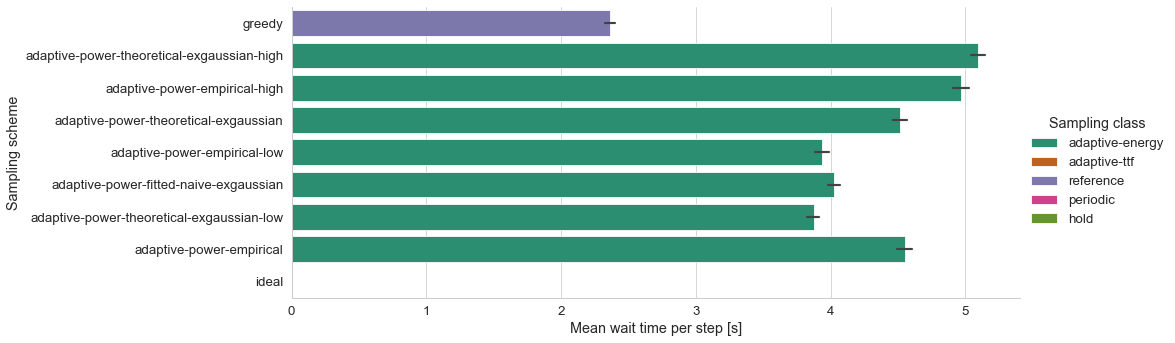

In [12]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="wait_time",
    # join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=False,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Mean wait time per step [s]", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

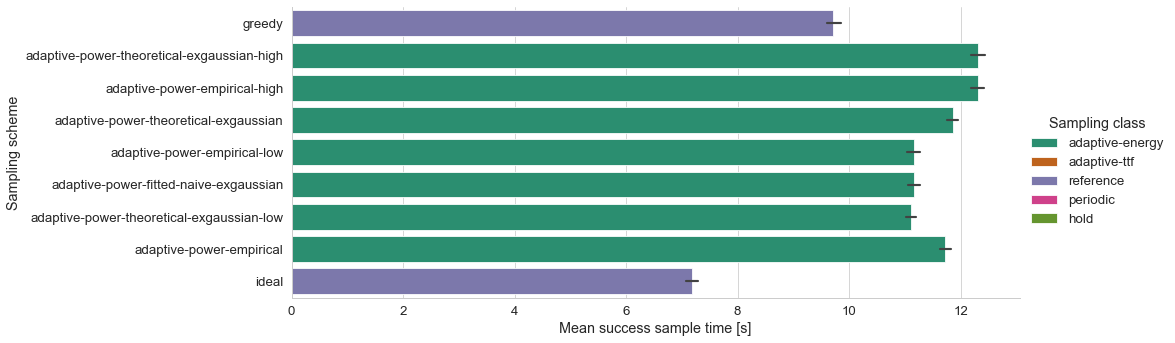

In [13]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="success_sample_instant",
    # join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=False,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Mean success sample time [s]", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

In [14]:
energies_maxrtt = results_per_rep.loc[(results_per_rep["rtt"] == results_per_rep["rtt"].max())].groupby(
    ["sampling_class", "sampling_scheme"])["energy"].describe(percentiles=[])
energies_maxrtt["var"] = np.square(energies_maxrtt["std"])
energies_maxrtt

count      mean  \
sampling_class  sampling_scheme                                               
adaptive-energy adaptive-power-empirical                     45.0  0.418106   
                adaptive-power-empirical-low                 45.0  0.420902   
                adaptive-power-empirical-high                45.0  0.425744   
                adaptive-power-theoretical-exgaussian        45.0  0.423419   
                adaptive-power-theoretical-exgaussian-low    45.0  0.419250   
                adaptive-power-theoretical-exgaussian-high   45.0  0.426076   
                adaptive-power-fitted-naive-exgaussian       45.0  0.420458   
reference       greedy                                       45.0  0.635760   
                ideal                                        45.0  0.323791   

                                                                 std  \
sampling_class  sampling_scheme                                        
adaptive-energy adaptive-power-empirical                    0.013845   
                adaptive-power-empirical-low                0.015904   
                adaptive-power-empirical-high               0.016157   
                adaptive-power-theoretical-exgaussian       0.015679   
                adaptive-power-theoretical-exgaussian-low   0.013631   
                adaptive-power-theoretical-exgaussian-high  0.016940   
                adaptive-power-fitted-naive-exgaussian      0.015640   
reference       greedy                                      0.019083   
                ideal                                       0.005866   

                                                                 min  \
sampling_class  sampling_scheme                                        
adaptive-energy adaptive-power-empirical                    0.391425   
                adaptive-power-empirical-low                0.388006   
                adaptive-power-empirical-high               0.398027   
                adaptive-power-theoretical-exgaussian       0.385437   
                adaptive-power-theoretical-exgaussian-low   0.393579   
                adaptive-power-theoretical-exgaussian-high  0.397991   
                adaptive-power-fitted-naive-exgaussian      0.395512   
reference       greedy                                      0.601200   
                ideal                                       0.311162   

                                                                 50%  \
sampling_class  sampling_scheme                                        
adaptive-energy adaptive-power-empirical                    0.415864   
                adaptive-power-empirical-low                0.422994   
                adaptive-power-empirical-high               0.423137   
                adaptive-power-theoretical-exgaussian       0.421852   
                adaptive-power-theoretical-exgaussian-low   0.417233   
                adaptive-power-theoretical-exgaussian-high  0.427010   
                adaptive-power-fitted-naive-exgaussian      0.421157   
reference       greedy                                      0.633600   
                ideal                                       0.323252   

                                                                 max       var  
sampling_class  sampling_scheme                                                 
adaptive-energy adaptive-power-empirical                    0.447077  0.000192  
                adaptive-power-empirical-low                0.451806  0.000253  
                adaptive-power-empirical-high               0.468409  0.000261  
                adaptive-power-theoretical-exgaussian       0.453071  0.000246  
                adaptive-power-theoretical-exgaussian-low   0.448355  0.000186  
                adaptive-power-theoretical-exgaussian-high  0.463475  0.000287  
                adaptive-power-fitted-naive-exgaussian      0.481448  0.000245  
reference       greedy                                      0.685800  0.000364  
 

In [15]:
import scipy.stats as stats

ix = pd.IndexSlice

# calculate the 95% CI for the difference between the means wrt to the ideal case
ideal_mean = energies_maxrtt.loc[ix["reference", "ideal"], "mean"]
ideal_var = energies_maxrtt.loc[ix["reference", "ideal"], "var"]
sample_size = results[(results["rtt"] == results["rtt"].max())].groupby("sampling_scheme").size().unique().take(0)

mean_diff = energies_maxrtt["mean"] - ideal_mean
t_critical = stats.t.ppf(q=0.95, df=sample_size + sample_size - 2)
spooled_variance = (((sample_size - 1) * np.square(energies_maxrtt["var"])) + (
            (sample_size - 1) * np.square(ideal_var))) / (sample_size + sample_size - 2)

t_factor = t_critical * np.sqrt(2 * np.square(spooled_variance) / sample_size)

energies_maxrtt["mean_diff_ideal"] = mean_diff
energies_maxrtt["mean_diff_ideal_95ci"] = t_factor

energies_maxrtt["mean_diff_ideal_percent"] = mean_diff / ideal_mean
energies_maxrtt["mean_diff_ideal_95ci_percent"] = t_factor / ideal_mean
energies_maxrtt

count      mean  \
sampling_class  sampling_scheme                                               
adaptive-energy adaptive-power-empirical                     45.0  0.418106   
                adaptive-power-empirical-low                 45.0  0.420902   
                adaptive-power-empirical-high                45.0  0.425744   
                adaptive-power-theoretical-exgaussian        45.0  0.423419   
                adaptive-power-theoretical-exgaussian-low    45.0  0.419250   
                adaptive-power-theoretical-exgaussian-high   45.0  0.426076   
                adaptive-power-fitted-naive-exgaussian       45.0  0.420458   
reference       greedy                                       45.0  0.635760   
                ideal                                        45.0  0.323791   

                                                                 std  \
sampling_class  sampling_scheme                                        
adaptive-energy adaptive-power-empirical                    0.013845   
                adaptive-power-empirical-low                0.015904   
                adaptive-power-empirical-high               0.016157   
                adaptive-power-theoretical-exgaussian       0.015679   
                adaptive-power-theoretical-exgaussian-low   0.013631   
                adaptive-power-theoretical-exgaussian-high  0.016940   
                adaptive-power-fitted-naive-exgaussian      0.015640   
reference       greedy                                      0.019083   
                ideal                                       0.005866   

                                                                 min  \
sampling_class  sampling_scheme                                        
adaptive-energy adaptive-power-empirical                    0.391425   
                adaptive-power-empirical-low                0.388006   
                adaptive-power-empirical-high               0.398027   
                adaptive-power-theoretical-exgaussian       0.385437   
                adaptive-power-theoretical-exgaussian-low   0.393579   
                adaptive-power-theoretical-exgaussian-high  0.397991   
                adaptive-power-fitted-naive-exgaussian      0.395512   
reference       greedy                                      0.601200   
                ideal                                       0.311162   

                                                                 50%  \
sampling_class  sampling_scheme                                        
adaptive-energy adaptive-power-empirical                    0.415864   
                adaptive-power-empirical-low                0.422994   
                adaptive-power-empirical-high               0.423137   
                adaptive-power-theoretical-exgaussian       0.421852   
                adaptive-power-theoretical-exgaussian-low   0.417233   
                adaptive-power-theoretical-exgaussian-high  0.427010   
                adaptive-power-fitted-naive-exgaussian      0.421157   
reference       greedy                                      0.633600   
                ideal                                       0.323252   

                                                                 max  \
sampling_class  sampling_scheme                                        
adaptive-energy adaptive-power-empirical                    0.447077   
                adaptive-power-empirical-low                0.451806   
                adaptive-power-empirical-high               0.468409   
                adaptive-power-theoretical-exgaussian       0.453071   
                adaptive-power-theoretical-exgaussian-low   0.448355   
                adaptive-power-theoretical-exgaussian-high  0.463475   
                adaptive-power-fitted-naive-exgaussian      0.481448   
reference       greedy                                      0.685800   
                ideal                                       0.335812   

                  

/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1092: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1093: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


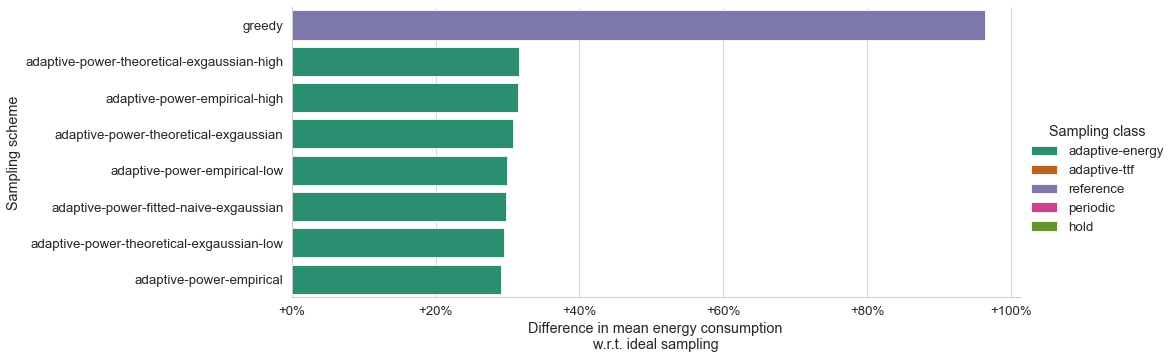

In [16]:
import matplotlib.ticker as tkr

plot_data = energies_maxrtt.reset_index().query("sampling_scheme != 'ideal'")

fg = sns.catplot(
    kind="bar",
    errorbar=None,
    data=plot_data,
    y="sampling_scheme",
    x="mean_diff_ideal_percent",
    aspect=3,
    xerr=plot_data["mean_diff_ideal_95ci_percent"],
    order=plot_data.sort_values("mean_diff_ideal", ascending=False)["sampling_scheme"],
    hue="sampling_class",
    dodge=False,
)
for ax in fg.axes.flat:
    # pass
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:+0.0%}"))

fg.set_axis_labels("Difference in mean energy consumption\nw.r.t. ideal sampling", "Sampling scheme")
fg.legend.set_title("Sampling class")
plt.show()

In [17]:
best_schemes = plot_data.sort_values("mean_diff_ideal", ascending=False)["sampling_scheme"][-5:]
best_schemes

3        adaptive-power-theoretical-exgaussian
1                 adaptive-power-empirical-low
6       adaptive-power-fitted-naive-exgaussian
4    adaptive-power-theoretical-exgaussian-low
0                     adaptive-power-empirical
Name: sampling_scheme, dtype: category
Categories (9, object): ['greedy' < 'ideal' < 'adaptive-power-empirical' < 'adaptive-power-empirical-low' ... 'adaptive-power-theoretical-exgaussian' < 'adaptive-power-theoretical-exgaussian-low' < 'adaptive-power-theoretical-exgaussian-high' < 'adaptive-power-fitted-naive-exgaussian']

In [18]:
results_best = results_per_rep[np.isin(results_per_rep["sampling_scheme"], best_schemes)].copy()
results_best["sampling_scheme"] = results_best["sampling_scheme"].cat.remove_unused_categories()
results_best

,timing_model,sampling_scheme,sampling_class,rtt,repetition,execution_time,step_duration,ttf,wait_time,samples,energy,idle_energy,comm_energy,idle_time,comm_time,success_sample_instant
450,empirical-high,adaptive-power-empirical,adaptive-energy,1.0,1,5.561410,8.114646,2.553236,1.553236,1.725000,0.157945,0.103607,0.054338,6.907146,1.207500,7.114646
451,empirical-high,adaptive-power-empirical,adaptive-energy,1.0,2,6.717046,9.163475,2.446429,1.446429,2.083333,0.181202,0.115577,0.065625,7.705142,1.458333,8.163475
452,empirical-high,adaptive-power-empirical,adaptive-energy,1.0,3,5.595048,8.144302,2.549254,1.549254,1.700000,0.157865,0.104315,0.053550,6.954302,1.190000,7.144302
453,empirical-high,adaptive-power-empirical,adaptive-energy,1.0,4,5.739748,8.310230,2.570482,1.570482,1.758333,0.161578,0.106191,0.055387,7.079396,1.230833,7.310230
454,empirical-high,adaptive-power-empirical,adaptive-energy,1.0,5,6.053931,8.630719,2.576788,1.576788,1.883333,0.169011,0.109686,0.059325,7.312385,1.318333,7.630719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,41,7.398076,16.188302,8.790226,3.790226,1.266667,0.421425,0.153525,0.267900,10.234968,5.953333,11.188302
2021,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,42,7.356517,16.265826,8.909309,3.909309,1.291667,0.426112,0.152925,0.273187,10.194993,6.070833,11.265826
2022,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,43,7.332996,16.253706,8.920710,3.920710,1.275000,0.423581,0.153918,0.269662,10.261206,5.992500,11.253706
2023,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,44,6.596412,15.575296,8.978884,3.978884,1.150000,0.395779,0.152554,0.243225,10.170296,5.405000,10.575296


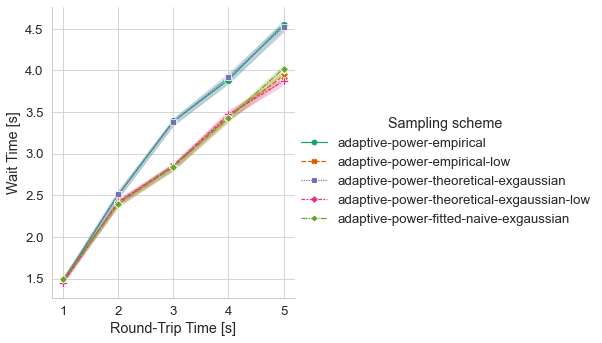

In [19]:
fg = sns.relplot(
    kind="line",
    errorbar=("ci", 95),
    data=results_best,
    x="rtt",
    y="wait_time",
    hue="sampling_scheme",
    style="sampling_scheme",
    markers=True,
    markersize=8,
)
fg.set_axis_labels("Round-Trip Time [s]", "Wait Time [s]")
fg.legend.set_title("Sampling scheme")
plt.show()